# Predicting Flight Delays: Regression Models

In [131]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [43]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [6]:
flights = pd.read_csv('../data/data-feature/flights-feature-edit.csv')

In [108]:
flights.rename(columns={'fl_date': 'date'}, inplace=True)

In [100]:
weather = pd.read_csv('../data/data-feature/flights_weather_feature_engineering.csv')

In [105]:
weather.drop('Unnamed: 0', axis=1, inplace=True)

In [106]:
weather.head()

,date,origin,dest,dep_delay,arr_delay,dep_avg_temp,dep_precip_mm,dep_humidity,dep_visibility,dep_total_snowcm,...,arr_snow,arr_rainy,arr_snow_bin,dep_snow_bin,arr_precip_bin,dep_precip_bin,dep_humidity_bin,arr_humidity_bin,dep_avgtemp_bin,arr_avgtemp_bin
0,2018-06-21,DFW,LGA,2.0,-8.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
1,2018-06-21,DFW,LGA,159.0,162.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
2,2018-06-21,DFW,LGA,43.0,40.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
3,2018-06-21,DCA,LGA,-5.0,-25.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
4,2018-06-21,DCA,LGA,18.0,23.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3


## Test 1: Only Flights Data! 

<b> Extract the following features: </b> carrier ID, tail num, origin, destination, arr delay, crs elapsed time

In [234]:
flights.columns

Index(['Unnamed: 0', 'date', 'mkt_unique_carrier', 'op_unique_carrier',
       'tail_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'dep_delay', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route', 'route_mean_delay', 'route_median_delay',
       'route_lq_delay', 'route_uq_delay', 'total_routes',
       'num_delayed_routes', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay'],
      dtype='object')

In [251]:
flights_df1 = flights.drop(['Unnamed: 0', 'date', 'mkt_unique_carrier', 'origin_airport_id', 'origin_city_name',
                           'dest_airport_id', 'dest_city_name', 'dep_delay', 'route', 'total_routes', 'num_delayed_routes'], axis=1)

In [252]:
flights_df1.shape

(980258, 30)

In [253]:
flights_df1.columns

Index(['op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay'],
      dtype='object')

In [254]:
flights_df1 = flights_df1.sample(frac=1)[:100000]

In [255]:
X = flights_df1.drop('arr_delay', axis=1)
y = flights_df1['arr_delay']

In [257]:
tail_num_le = LabelEncoder()
X['tail_num'] = tail_num_le.fit_transform(X['tail_num'])

# Label encode origin and destination
airports_le = LabelEncoder()
X['origin'] = airports_le.fit_transform(X['origin'])
X['dest'] = airports_le.fit_transform(X['dest'])

# label encode mkt_carrier
mkt_carrier_le = LabelEncoder()
X['op_unique_carrier'] = mkt_carrier_le.fit_transform(X['op_unique_carrier'])

In [258]:
dummies = pd.get_dummies(X[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X = pd.concat([X, dummies], axis=1)

In [259]:
X.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [260]:
len(X.columns)

45

In [261]:
X

,op_unique_carrier,tail_num,origin,dest,crs_elapsed_time,distance,month,day,month_arr_delay_avg,month_dep_delay_avg,...,arr_time_desc_morning,arr_time_desc_noon,orr_busy_high,orr_busy_low,orr_busy_medium,orr_busy_medium-high,arr_busy_high,arr_busy_low,arr_busy_medium,arr_busy_medium-high
454477,16,4362,201,295,89.0,292,2,13,-6.0,-2.0,...,0,0,0,0,0,1,0,0,1,0
411123,5,3367,116,326,231.0,1608,5,15,-6.0,-2.0,...,0,0,0,0,0,1,0,0,1,0
882734,21,3109,263,308,135.0,784,8,12,-5.0,-2.0,...,0,0,0,0,1,0,0,1,0,0
856290,8,6180,21,234,81.0,302,4,22,-7.0,-3.0,...,0,0,1,0,0,0,0,1,0,0
46751,8,1748,21,92,103.0,547,3,10,-6.0,-2.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679891,22,3851,192,71,267.0,2052,4,5,-7.0,-3.0,...,0,0,1,0,0,0,0,0,1,0
893207,25,5222,268,122,93.0,493,8,2,-5.0,-2.0,...,0,0,0,0,0,1,0,0,1,0
588997,17,3467,93,202,218.0,1389,8,23,-5.0,-2.0,...,0,1,1,0,0,0,0,0,0,1
790954,2,152,181,193,369.0,2475,10,10,-7.0,-3.0,...,0,1,0,0,0,1,1,0,0,0


In [262]:
X_transformed = X.to_numpy()
y_transformed = y.to_numpy().reshape(-1,1)

In [263]:
'''
number_of_rows = X_transformed.shape[0]
random_indices = np.random.choice(number_of_rows, size=100000, replace=False)
X_transformed_sample = X_transformed[random_indices, :]

number_of_rows = y.shape[0]
y_sample = y[random_indices]

X_transformed_sample.shape, y_sample.shape
'''

'\nnumber_of_rows = X_transformed.shape[0]\nrandom_indices = np.random.choice(number_of_rows, size=100000, replace=False)\nX_transformed_sample = X_transformed[random_indices, :]\n\nnumber_of_rows = y.shape[0]\ny_sample = y[random_indices]\n\nX_transformed_sample.shape, y_sample.shape\n'

In [264]:
X_transformed

array([[1.600e+01, 4.362e+03, 2.010e+02, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [5.000e+00, 3.367e+03, 1.160e+02, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.100e+01, 3.109e+03, 2.630e+02, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.700e+01, 3.467e+03, 9.300e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.000e+00, 1.520e+02, 1.810e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [8.000e+00, 1.919e+03, 2.390e+02, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [265]:
xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y_transformed, test_size=0.2)

In [72]:
import xgboost as xgb

In [73]:
xg_reg = xgb.XGBRegressor()

xg_reg.fit(xtrain, ytrain)
xg_reg.score(xtest, ytest)

0.09313127557387135

In [74]:
rfr = RandomForestRegressor()

In [75]:
rfr.fit(xtrain, ytrain)

RandomForestRegressor()

In [77]:
rfr.score(xtest, ytest)

0.09954940836433201

In [50]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

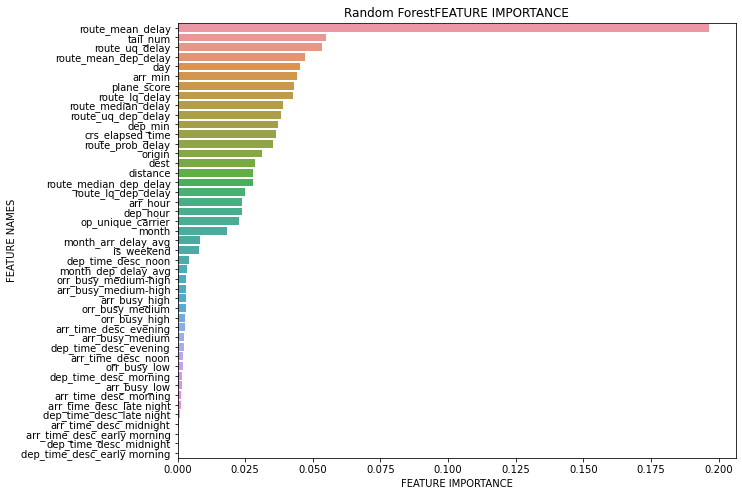

In [81]:
plot_feature_importance(rfr.feature_importances_, X.columns, 'Random Forest')

In [52]:
len(rfr.feature_importances_)

45

In [55]:
X.columns

Index(['op_unique_carrier', 'tail_num', 'origin', 'dest', 'crs_elapsed_time',
       'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay'],
      dtype='object')

In [266]:
gbr = GradientBoostingRegressor()

In [267]:
gbr.fit(xtrain, ytrain)

GradientBoostingRegressor()

In [268]:
gbr.score(xtest, ytest)

0.14574806906254678

In [269]:
y_pred = gbr.predict(xtest)

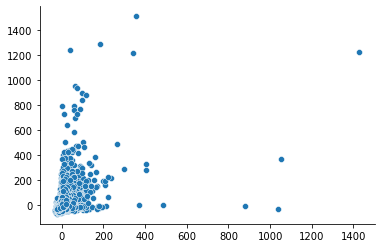

In [274]:
sns.scatterplot(x=y_pred, y=ytest.reshape(1,-1)[0])
sns.despine()
plt.show()

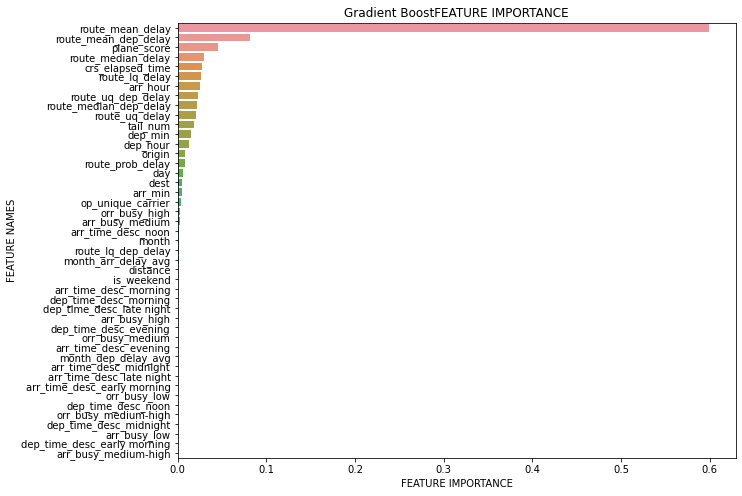

In [82]:
plot_feature_importance(gbr.feature_importances_, X.columns, 'Gradient Boost')

## Test 2: Only Flights Data - Drop a few features!

In [84]:
flights_df2 = flights[['route_mean_delay', 'route_mean_dep_delay', 'plane_score', 'route_median_delay', 'crs_elapsed_time',
                      'route_lq_delay', 'arr_hour', 'route_uq_delay', 'tail_num', 'dep_min', 'dep_hour', 'origin', 'route_prob_delay',
                      'dest', 'arr_min', 'arr_delay']]

In [ ]:
flights_df2 = flights_df2.sample(frac=1)[:100000]

In [93]:
X = flights_df2.drop('arr_delay', axis=1)
y = flights_df2['arr_delay']

In [95]:
tail_num_le = LabelEncoder()
X['tail_num'] = tail_num_le.fit_transform(X['tail_num'])

# Label encode origin and destination
airports_le = LabelEncoder()
X['origin'] = airports_le.fit_transform(X['origin'])
X['dest'] = airports_le.fit_transform(X['dest'])

In [96]:
X_transformed = X.to_numpy()
y_transformed = y.to_numpy().reshape(-1,1)

((100000, 15), (100000,))

In [97]:
xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y_transformed, test_size=0.2)

In [98]:
gbr = GradientBoostingRegressor()

In [99]:
gbr.fit(xtrain, ytrain)
gbr.score(xtest, ytest)

0.13102252051156782

## Test 3: Incorporating Weather Data

In [275]:
flights_df3 = pd.merge(flights, weather, on=['date','origin', 'dest'], how='inner')

In [276]:
flights_df3.shape

(102479, 73)

In [277]:
flights_df3 = flights_df3.drop_duplicates()

In [278]:
flights_df3.shape

(102263, 73)

In [279]:
flights_df3 = flights_df3[['op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay_x', 'crs_elapsed_time',
                          'distance', 'month', 'day', 'month_arr_delay_avg', 'month_dep_delay_avg', 'is_weekend',
                          'dep_hour', 'dep_min', 'arr_hour', 'arr_min', 'dep_time_desc', 'arr_time_desc',
                          'plane_score', 'orr_busy', 'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay', 'route_uq_delay',
                          'route_prob_delay','route_mean_dep_delay', 'route_median_dep_delay', 'route_lq_dep_delay',
                           'route_uq_dep_delay','dep_avg_temp',
                           'dep_precip_mm', 'dep_humidity', 'dep_visibility', 'dep_total_snowcm',
                           'dep_windspeed', 'arr_avg_temp',
                            'arr_precip_mm', 'arr_humidity', 'arr_visibility', 'arr_total_snowcm',
                           'arr_windspeed']]

In [280]:
flights_df3.rename(columns={'arr_delay_x': 'arr_delay'}, inplace=True)

In [281]:
flights_df3.head()

,op_unique_carrier,tail_num,origin,dest,arr_delay,crs_elapsed_time,distance,month,day,month_arr_delay_avg,...,dep_humidity,dep_visibility,dep_total_snowcm,dep_windspeed,arr_avg_temp,arr_precip_mm,arr_humidity,arr_visibility,arr_total_snowcm,arr_windspeed
0,UA,N76288,SEA,ORD,-19.0,239.0,1721,3,27,-6.0,...,57,10,0.0,13,24,0.0,48,10,0.0,5
1,UA,N845UA,SEA,ORD,-12.0,240.0,1721,3,12,-6.0,...,73,9,0.0,13,24,0.0,63,10,0.0,12
2,UA,N76269,SEA,ORD,-12.0,237.0,1721,3,26,-6.0,...,54,10,0.0,9,26,0.0,49,10,0.0,4
3,UA,N76269,SEA,ORD,-12.0,237.0,1721,3,26,-6.0,...,54,10,0.0,9,26,0.0,49,10,0.0,4
4,UA,N33262,SEA,ORD,-16.0,239.0,1721,3,26,-6.0,...,54,10,0.0,9,26,0.0,49,10,0.0,4


In [282]:
flights_df3 = flights_df3.sample(frac=1)[:100000]

In [283]:
X = flights_df3.drop('arr_delay', axis=1)
y = flights_df3['arr_delay']

In [284]:
tail_num_le = LabelEncoder()
X['tail_num'] = tail_num_le.fit_transform(X['tail_num'])

# Label encode origin and destination
airports_le = LabelEncoder()
X['origin'] = airports_le.fit_transform(X['origin'])
X['dest'] = airports_le.transform(X['dest'])

# label encode mkt_carrier
mkt_carrier_le = LabelEncoder()
X['op_unique_carrier'] = mkt_carrier_le.fit_transform(X['op_unique_carrier'])

In [285]:
dummies = pd.get_dummies(X[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X = pd.concat([X, dummies], axis=1)

In [286]:
X.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [287]:
X_transformed = X.to_numpy()

In [288]:
X_transformed

array([[1.500e+01, 1.621e+03, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [6.000e+00, 2.997e+03, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.300e+01, 2.610e+02, 6.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 1.890e+02, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.000e+00, 3.414e+03, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.000e+00, 1.350e+02, 4.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [289]:
y_transformed = y.to_numpy().reshape(-1,1)

In [290]:
xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y_transformed, test_size=0.2)

In [291]:
gbr = GradientBoostingRegressor()

In [292]:
gbr.fit(xtrain, ytrain)
gbr.score(xtest, ytest)

0.14493702396483887

In [293]:
y_pred_weather = gbr.predict(xtest)

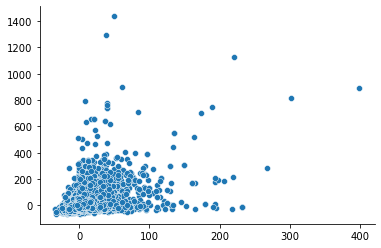

In [294]:
sns.scatterplot(x=y_pred_weather, y=ytest.reshape(1,-1)[0])
sns.despine()
plt.show()